In [1]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import KeyedVectors

nlp = spacy.load('en')
#keyedv= KeyedVectors.load_word2vec_format('../dataset/wiki.en.vec')

dtypes ={
    'id': np.uint32,
    'qid1': np.uint32,
    'qid2': np.uint32,
    'question1': np.str,
    'question2': np.str,
    'is_duplicate': np.uint8
}

df = pd.read_csv('../dataset/quora_train.csv', dtype=dtypes)

In [2]:
def compare_noun(q1, q2):
    q1 = q1 if type(q1) is str else ''
    q2 = q2 if type(q2) is str else ''
    
    qt1 = [t for t in nlp(q1) if t.tag_.startswith('N')]# or t.tag_.startswith('V') or t.tag_.startswith('J')]
    qt2 = [t for t in nlp(q2) if t.tag_.startswith('N')]# or t.tag_.startswith('V') or t.tag_.startswith('J')]
    
    count = 0
    s_sum = 0
    for t1 in qt1:
        for t2 in qt2:
            s_sum += t1.similarity(t2)
            count += 1                  
    
    return s_sum / count if count != 0 else 0

In [3]:
from multiprocessing import Pool
pool = Pool(4)

df['compare_noun'] = pool.starmap(compare_noun, tuple(zip(df.question1, df.question2)))
pool.close()

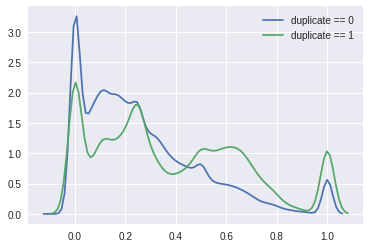

In [4]:
sns.kdeplot(df[df.is_duplicate==0].compare_noun, label="duplicate == 0")
sns.kdeplot(df[df.is_duplicate==1].compare_noun, label="duplicate == 1")

In [5]:
def compare_verb(q1, q2):
    q1 = q1 if type(q1) is str else ''
    q2 = q2 if type(q2) is str else ''
    
    qt1 = [t for t in nlp(q1) if t.tag_.startswith('V')]
    qt2 = [t for t in nlp(q2) if t.tag_.startswith('V')]
    
    count = 0
    s_sum = 0
    for t1 in qt1:
        for t2 in qt2:
            s_sum += t1.similarity(t2)
            count += 1                  
    
    return s_sum / count if count != 0 else 0

from multiprocessing import Pool
pool = Pool(4)

df['compare_verb'] = pool.starmap(compare_verb, tuple(zip(df.question1, df.question2)))

pool.close()

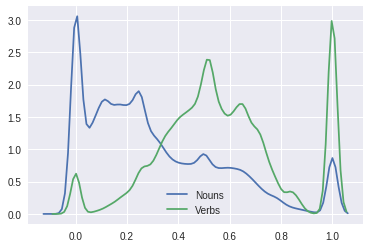

In [6]:
sns.kdeplot(df.compare_noun, label="Nouns")
sns.kdeplot(df.compare_verb, label="Verbs")

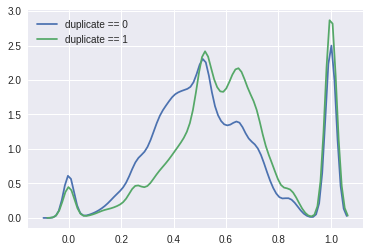

In [7]:
sns.kdeplot(df[df.is_duplicate==0].compare_verb, label="duplicate == 0")
sns.kdeplot(df[df.is_duplicate==1].compare_verb, label="duplicate == 1")

In [8]:
def compare_noun_max(q1, q2):
    if len(q2) > len(q1):
        q1, q2 = q2, q1
    
    q1 = q1 if type(q1) is str else ''
    q2 = q2 if type(q2) is str else ''
    
    qt1 = [t for t in nlp(q1) if t.tag_.startswith('N')]
    qt2 = [t for t in nlp(q2) if t.tag_.startswith('N')]
    
    s_sum = 0
    for t1 in qt1:
        s_sum = max([t1.similarity(t2) for t2 in qt2])
               
    
    return s_sum / len(qt1) if len(qt1) != 0 else 0

from multiprocessing import Pool
pool = Pool(4)

df['compare_noun_max'] = pool.starmap(compare_verb, tuple(zip(df.question1, df.question2)))
pool.close()

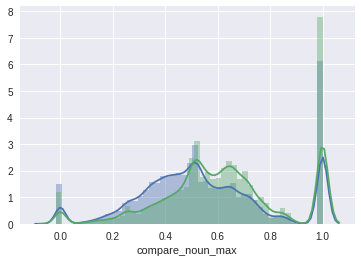

In [9]:
sns.distplot(df[df.is_duplicate==0].compare_noun_max, label="duplicate == 0")
sns.distplot(df[df.is_duplicate==1].compare_noun_max, label="duplicate == 1")

In [ ]:
import xgboost as xgb

X = df[['compare_noun', 'compare_verb', 'compare_noun_max']]
y = df[['is_duplicate']]

gbm = xgb.XGBClassifier(max_depth=10, n_estimators=200).fit(X[:300000], y[:300000])

/home/sml/.pyenv/versions/3.5.1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sml/.pyenv/versions/3.5.1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sml/.pyenv/versions/3.5.1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_o

In [ ]:
from tqdm import tqdm

output = open('result.csv', 'w')
output.write('test_id,is_duplicate\n')

df_test = pd.read_csv('../dataset/quora_test.csv', dtype=dtypes, iterator=True, chunksize=10000)

for chunk in tqdm(df_test):
    pool = Pool(4)
    chunk['compare_noun'] = pool.starmap(compare_noun, tuple(zip(chunk.question1, chunk.question2)))
    chunk['compare_verb'] = pool.starmap(compare_verb, tuple(zip(chunk.question1, chunk.question2)))
    chunk['compare_noun_max'] = pool.starmap(compare_verb, tuple(zip(chunk.question1, chunk.question2)))
    prediction = gbm.predict_proba(chunk[['compare_noun', 'compare_verb', 'compare_noun_max']])
    pool.close()
    
    for i, p in zip(chunk['test_id'], prediction):
        output.write('{},{}\n'.format(i, p[1]))

181it [34:50, 11.47s/it]

### Score: 0.50479